Epoch 1/100, Loss: 33.2636, Train Acc: 50.14%, Val Acc: 57.21%, Time: 2.30s
Epoch 2/100, Loss: 24.6709, Train Acc: 58.84%, Val Acc: 55.69%, Time: 2.38s
Epoch 3/100, Loss: 22.4862, Train Acc: 60.43%, Val Acc: 62.57%, Time: 2.34s
Epoch 4/100, Loss: 20.4927, Train Acc: 63.80%, Val Acc: 63.85%, Time: 2.34s
Epoch 5/100, Loss: 18.4123, Train Acc: 66.00%, Val Acc: 71.43%, Time: 2.32s
Epoch 6/100, Loss: 16.4301, Train Acc: 71.42%, Val Acc: 73.44%, Time: 2.32s
Epoch 7/100, Loss: 14.9398, Train Acc: 73.25%, Val Acc: 73.35%, Time: 2.33s
Epoch 8/100, Loss: 13.6208, Train Acc: 75.54%, Val Acc: 78.26%, Time: 2.32s
Epoch 9/100, Loss: 13.0551, Train Acc: 77.03%, Val Acc: 79.24%, Time: 2.33s
Epoch 10/100, Loss: 12.0237, Train Acc: 78.58%, Val Acc: 77.60%, Time: 2.34s
Epoch 11/100, Loss: 11.4650, Train Acc: 79.70%, Val Acc: 84.83%, Time: 2.35s
Epoch 12/100, Loss: 10.5136, Train Acc: 81.06%, Val Acc: 79.89%, Time: 2.35s
Epoch 13/100, Loss: 9.7806, Train Acc: 82.46%, Val Acc: 82.74%, Time: 2.35s
Epoch 14/

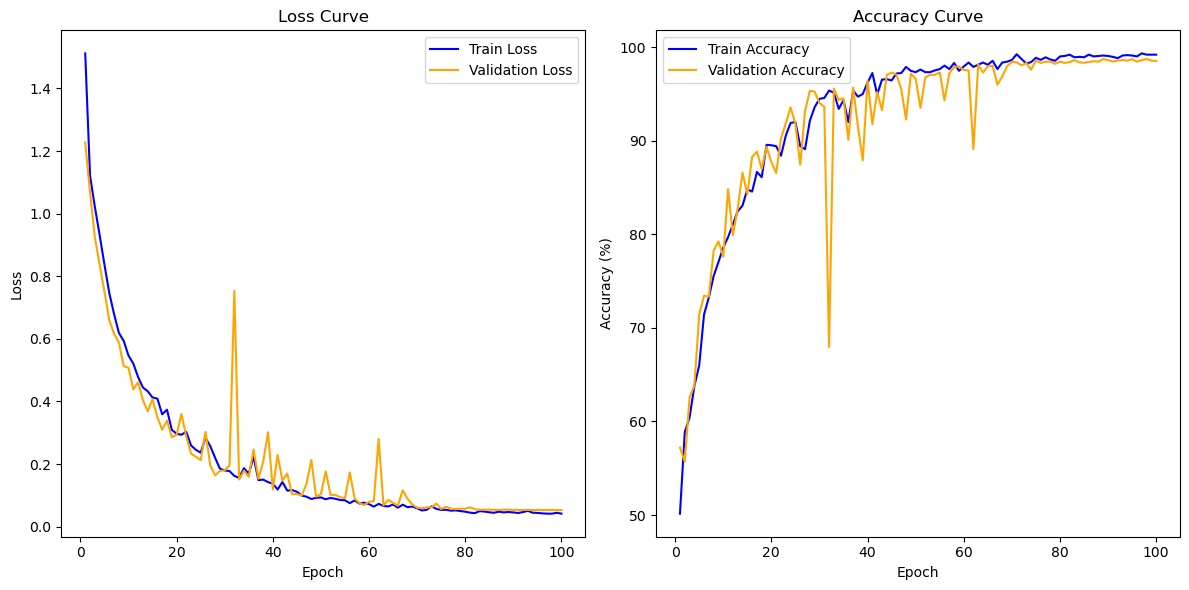

Test Accuracy: 98.56%
Overall Accuracy (OA): 98.56%
Kappa Coefficient: 0.98
Average Accuracy (AA): nan%


C:\Users\RAAGAVAN\AppData\Local\Temp\ipykernel_4652\1689686832.py:228: RuntimeWarning: invalid value encountered in divide
  class_accuracies = np.diag(cm) / np.sum(cm, axis=1)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from MVAHN import MVAHN  # Make sure to import your MVAHN model
from sklearn.metrics import confusion_matrix

# ----------------------- Data Loading and Preprocessing -----------------------
# Load the dataset
def load_indian_pines(file_path, gt_path):
    data = scipy.io.loadmat(file_path)['paviaU']
    labels = scipy.io.loadmat(gt_path)['paviaU_gt']
    return data, labels

# Extract patches
def extract_patches(data, labels, patch_size=11):
    margin = patch_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='reflect')
    patches = []
    patch_labels = []

    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            if labels[i - margin, j - margin] > 0:  # Ignore unlabeled pixels
                patch = padded_data[i - margin:i + margin + 1, j - margin:j + margin + 1, :]
                patches.append(patch)
                patch_labels.append(labels[i - margin, j - margin] - 1)  # Zero-indexed labels

    return np.array(patches), np.array(patch_labels)

# Split data
def split_data(patches, patch_labels, train_ratio=0.8, val_ratio=0.1):
    train_size = train_ratio
    test_size = 1 - train_size - val_ratio

    X_train, X_temp, y_train, y_temp = train_test_split(
        patches, patch_labels, test_size=(1 - train_size), random_state=42, stratify=patch_labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(test_size / (val_ratio + test_size)), random_state=42, stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

# Dataset Class
class IndianPinesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        patch = torch.tensor(self.data[idx], dtype=torch.float32).permute(2, 0, 1)  # Channels first
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return patch, label

# Create DataLoaders
def create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=100):
    train_dataset = IndianPinesDataset(X_train, y_train)
    val_dataset = IndianPinesDataset(X_val, y_val)
    test_dataset = IndianPinesDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# ----------------------- Model Training -----------------------
# Define evaluation loop
def evaluate_model_with_loss(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(loader)

    # Flatten the predictions and labels to calculate confusion matrix
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return accuracy, avg_loss, all_preds, all_labels

# Define training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100):
    model.train()
    
    # Lists to store loss and accuracy for plotting
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    val_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        start_time = time.time()

        model.train()  # Set model to training mode
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Calculate train accuracy
        train_acc = 100 * correct / total
        # Calculate validation accuracy and loss
        val_acc, val_loss, _, _ = evaluate_model_with_loss(model, val_loader, criterion)

        scheduler.step()
        
        # Store values for plotting
        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        end_time = time.time()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Acc: {val_acc:.2f}%, Time: {end_time - start_time:.2f}s")
    
    # Plotting the graphs
    plot_graphs(train_losses, train_accuracies, val_losses, val_accuracies, num_epochs)

# Plot the graphs for loss and accuracy
def plot_graphs(train_losses, train_accuracies, val_losses, val_accuracies, num_epochs):
    # Plotting Loss and Accuracy
    epochs = np.arange(1, num_epochs + 1)
    
    # Plotting training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color='blue')
    plt.plot(epochs, val_losses, label="Validation Loss", color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ----------------------- Main Script -----------------------
# File paths
file_path = "C:\\Users\\RAAGAVAN\\PAVAN\\Dataset\\PaviaU.mat"
gt_path = "C:\\Users\\RAAGAVAN\\PAVAN\\Dataset\\PaviaU_gt.mat"

# Load and preprocess data
data, labels = load_indian_pines(file_path, gt_path)
patches, patch_labels = extract_patches(data, labels, patch_size=11)

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(patches, patch_labels, train_ratio=0.05, val_ratio=0.1)

# Create DataLoaders
train_loader, val_loader, test_loader = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=100)

# Initialize model, loss, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MVAHN(channels=103, num_classes=9, image_size=11, datasetname="PaviaUniversity").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100)

# Evaluate the model on the test set
test_acc, _, test_preds, test_labels = evaluate_model_with_loss(model, test_loader, criterion)
print(f"Test Accuracy: {test_acc:.2f}%")

def calculate_kappa(true_labels, predicted_labels, num_classes):
    cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(num_classes))
    total = np.sum(cm)
    sum_po = np.sum(np.diag(cm))
    sum_pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / total
    kappa = (sum_po - sum_pe) / (total - sum_pe)
    return kappa

def calculate_average_accuracy(true_labels, predicted_labels, num_classes):
    cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(num_classes))
    class_accuracies = np.diag(cm) / np.sum(cm, axis=1)
    return np.mean(class_accuracies) * 100

# Calculate Overall Accuracy (OA), Kappa Coefficient, and Average Accuracy (AA)
oa = 100 * np.sum(test_preds == test_labels) / len(test_labels)
kappa = calculate_kappa(test_labels, test_preds, num_classes=16)
aa = calculate_average_accuracy(test_labels, test_preds, num_classes=16)

print(f"Overall Accuracy (OA): {oa:.2f}%")
print(f"Kappa Coefficient: {kappa:.2f}")
print(f"Average Accuracy (AA): {aa:.2f}%")

# ----------------------- Utility Functions -----------------------

